The following code template comes with placeholders (marked with `YOUR CODE HERE`) and has to be filled with the appropriate logic as described in the function descriptions.
Some cells consist of assertions about the expected functionality, and aid you in getting it right.
They are not meant to be edited.
Moreover, there are also hidden assertions that will test your environment for edge cases.
Each correct assertion rewards you points for this assignment.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [2]:
NAME = "SHIVARAM GOUTHAM SURESH"
COLLABORATORS = "PRAMOD MAHAJAN CHIKKABALLEKERE MANJUNATHA"

_Please note that only one collaborator is allowed in all assignments, that is, only two persons per group. We expect independent submissions per group. All deviations will be sanctioned._

---

# Implement a DQN-Agent for the Acrobot

# Introduction
In this home assignment you are supposed to solve the [acrobot environment](https://gym.openai.com/envs/Acrobot-v1/) with a DQN agent.

*The acrobot system includes two joints and two links, where the joint between the two links is actuated. Initially, the links are hanging downwards, and the goal is to swing the end of the lower link up to a given height.*

However, we raise the bar on this environment by posing the task to balance the two joints upwards as long as possible instead of just reaching a certain height. 

**Please note that this is an ambitious control task and you may not expect your agent to actually balance the acrobot to an upward position permanently**.

![](acrobot_example.gif)

# DQN Agent
A [Deep Q-Network](https://arxiv.org/abs/1312.5602) is the combination of tabular Q-Learning with a neural network as non-linear function approximator.
Among approximating the Q-value with a certain parameter set $\boldsymbol w$, a DQN agent relies on an _experience replay_ buffer.

A certain amount of samples from the experience replay buffer is randomly drawn at each step to make up a mini-batch $\mathcal D_b$, which contributes to the weight update.

This procedure has following benefits:
* Each sample is potentially used several times for weight updates, increasing the data efficiency.
* Random sampling breaks up with the high correlation of consecutive environment observations, which tend to drift weight updates into a only temporarily expedient direction, potentially leading to weights diverge or oscillate. Update variance is effectively reduced.

Since an experience replay buffer (or also *memory buffer*) makes the algorithm off-policy, Q-Learning lends itself to the weight updates.
Note, that the memory buffer is of fixed size and contains merely the last observations.
Prioritized sampling is not part of the [original algorithm](https://arxiv.org/abs/1312.5602), but has been [suggested not long after](https://arxiv.org/abs/1511.05952).

The DQN, in [an improved form](https://www.nature.com/articles/nature14236), adds a twist to the weight updates:
The loss $\mathcal L(\boldsymbol w)$ is calculated against a so-called *target network*, which is just the same DQN with an older snapshot of its weights, where the target network is updated with the current *online network* every few steps.

$$\mathcal L(\boldsymbol w) = [(r + \gamma \text{max}_u \hat q (x', u, \boldsymbol w^-)) - \hat q(x,u,\boldsymbol w)]_{\mathcal D_b}^2 $$

with $\boldsymbol w^-$ denoting the target network's weights.

# Task Details

The only external libraries allowed for the DQN implementation are:
* Tensorflow/ Keras
* Pytorch
* Numpy
* Scikit-Learn

You can conduct a hyperparameter optimization to search for optimal parameters.

**Please refrain from using readily implemented algorithms from GitHub, which, however, can be analyzed for inspiration and understanding of the algorithm of course.**

### Point distribution

* Feature engineering (3 Points)
* Decide (3 points)
* Deliberate(15 points)
* Smoke-test (do train() and test() run without errors? 2 points)
* After training, is the cumulative reward per episode on average over -100? (5 points)
* Plot the learning curve, that is, the cumulated reward of each episode over the course of training (2 points)


# 1. Compete with your DQN algorithm (28 points)

Use the following templates for the DQN implementation. 

Note that the DQN class comes with a complete training and test routine. 
These routines will be used to evaluate your agent's performance and will be publicly ranked in a leaderboard after submission (showing matr. nr. only).
It might be the case, that you are overly restricted by the train routine. In this case we allow for adapting this function to your needs.
However, please refrain from adjusting the test routine.


In [3]:
import numpy as np
import gym
import random
import time
from collections import deque
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [4]:
class HardMode(gym.Wrapper):
    """Modified Acrobot: Reward is the negative cosine of both absolute angles.
    An episode never terminates prematurely - the goal is to hold the two links 
    straight upwards as long as possible within a fix amount of steps per episode.
    Instead of three actions, there are five for a fine-grained control"""
    
    def __init__(self, env, **kwargs):
        new_actions = np.linspace(-.5, .5, 5).round(2).tolist()
        env.env.AVAIL_TORQUE = new_actions
        super().__init__(env, **kwargs)
        self.action_space = gym.spaces.Discrete(len(new_actions))
                               
    def step(self, action):
        state, rew, done, misc = super().step(action)
        
        # scale state
        state[4] /= self.env.MAX_VEL_1
        state[5] /= self.env.MAX_VEL_2
        # All states are within [-1, 1] now
        
        # Having the inner link pointing up is twice as important.
        s = self.env.state
        rew = - .666*np.cos(s[0]) - .333*np.cos(s[1] + s[0])
        
        done = False  # never terminate internally
        return state, rew, done, misc

In [5]:
# add your imports
# YOUR CODE HERE
from keras.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam
from keras.losses import mean_squared_error
from keras.initializers import RandomUniform, TruncatedNormal
#raise NotImplementedError()

# DQN Agent template
class DQNController:
    """This class represents the DQN learning algorithm."""

    def __init__(self, environment):
        self.env = environment
        self.n_states = self.env.observation_space.shape[0] 
        
        # Whatever attributes are needed go here
        # YOUR CODE HERE
        self.n_states = self.env.observation_space.shape
        self.memory  = deque(maxlen=500000)
        self.epsilon_min = 0.0001
        self.gamma = 0.99
        self.epsilon = 0.9
        self.epsilon_decay = 0.95
        self.learning_rate = 0.001
        self.batch_size = 128
        
        self.online_network = Sequential(
            [
                Dense(512, activation="relu", input_shape=self.n_states),
                Dense(256, activation="relu",),
                Dense(self.env.action_space.n),
            ]
        )
        self.target_network = Sequential(
            [
                Dense(512, activation="relu",input_shape=self.n_states),
                Dense(256, activation="relu", ),
                Dense(self.env.action_space.n),
            ]
        )
        self.target_network.set_weights(self.online_network.get_weights())
        self.online_network.compile(loss="mse", optimizer=Adam(lr=self.learning_rate), metrics=['accuracy'])

        #raise NotImplementedError()

        # a boolean switch between epsilon-greedy (training) and greedy (testing)
        self.training_mode = True

    def preprocess(func):
        """This function wraps the agent's 'decide' and 'deliberate' function. 
        You can implement normalization, scaling, and feature engineering here.
        This function is worth 3 points."""
        # YOUR CODE HERE
        # States are normalised, rest of the things are directly handeled in delibrate function
        return
        #raise NotImplementedError()

    #@preprocess
    def decide(self, observation):
        """Take a decision.
        This function is worth 3 points."""

        # YOUR CODE HERE
        if self.epsilon < np.random.rand(1):
            action = np.argmax(self.online_network.predict(np.array([observation])))
        else:
            action = random.choice(range(self.env.action_space.n))
        #raise NotImplementedError()

        return action

    #@preprocess
    def _deliberate(self, observation, reward=0, done=False):
        """Deliberate over what happened. This function contains the main
        logic for the DQN algorithm.
        This function is worth 15 points."""

        # YOUR CODE HERE
        
        if len(self.memory) < self.batch_size:
            return
        # YOUR CODE HERE
        
        # sample from experience
        samples = random.sample(self.memory, self.batch_size)
        
        # seperating states and next_states for prediction
        state_for_pred = []
        next_state_for_pred = []         
        for i in range(len(samples)):
            state_for_pred.append(samples[i][0])
            next_state_for_pred.append(samples[i][3])
            
        # Collect all predictions
        next_pred = self.target_network.predict_on_batch(np.array(next_state_for_pred))   
        current_pred = self.online_network.predict_on_batch(np.array(state_for_pred))
        
        # collecting states to fit
        target_list = np.empty((0,self.env.action_space.n))
        state_coll = []
        
        for sample,i in zip(samples,range(len(samples))):
            state, action, reward, new_state = sample
            state_coll.append(state)
            target = [list(current_pred[i])]
            if done:
                target[0][action] = reward 
            else:
                Next_Q_value = max(next_pred[i])
                target[0][action] = reward + Next_Q_value * self.gamma
            target_list = np.vstack((target_list,target))
            
        # Train model on batch
        self.online_network.train_on_batch(np.array(state_coll), target_list)

        #raise NotImplementedError()
    # as mentioned above, training has been modified accordingly
    def train(self, n_episodes=300, max_episode_len=512, visualize=True):
        self.training_mode = True
        train_log = {'cum_rew': []}
        for ep in tqdm(range(n_episodes)):
            state = self.env.reset() 
            k = 0
            count = 0
            cum_rew = 0
            done = False
            while not done:
                action = self.decide(state)
                next_state, reward, done, _ = self.env.step(action)
                done = done or k == (max_episode_len - 1)  # force done after max_episodes
                self.memory.append([state, action, reward, next_state])
                self._deliberate(next_state, reward, done)
                state = next_state
                if count % 800 == 0:
                    self.target_network.set_weights(self.online_network.get_weights())
                k += 1
                count += 1
                cum_rew += reward
                if visualize:
                    self.env.render(mode='human')
            train_log['cum_rew'].append(cum_rew)
            
            # Epsilon decay every episode
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            elif self.epsilon <= self.epsilon_min:
                self.epsilon = self.epsilon_min
                
            # to be sure epsilon is at minimun before entering testing mode    
            if ep == (n_episodes - 1):
                self.epsilon = self.epsilon_min
                print('epsilon set')
                
        return train_log

    def test(self, n_episodes=20, max_episode_len=512, visualize=False):
        self.training_mode = False
        log = {'cum_rew': []}
        for ep in tqdm(range(n_episodes)):
            state = self.env.reset()
            k = 0
            cum_rew = 0
            done = False
            while not done:
                action = self.decide(state)
                state, reward, done, _ = self.env.step(action)
                done = done or k == (max_episode_len - 1)  # force done after max_episodes
                k+=1
                cum_rew += reward
                if visualize:
                    self.env.render(mode='human')
            log['cum_rew'].append(cum_rew)
        print(f'tested for {ep+1} episodes')
        return log

Using TensorFlow backend.


In [6]:
agent = DQNController(HardMode(gym.make('Acrobot-v1')))
train_logs = agent.train(visualize=False)
test_logs = agent.test(visualize=False)  # Set visualize to True for render mode

epsilon set




tested for 20 episodes


In [7]:
# hidden checks. Ignore this cell.

In [8]:
# hidden checks. Ignore this cell.

## Plot the learning curve (2 points)
Illustrate the cumulated reward per episode during training. Focus on readability and proper labeling. 

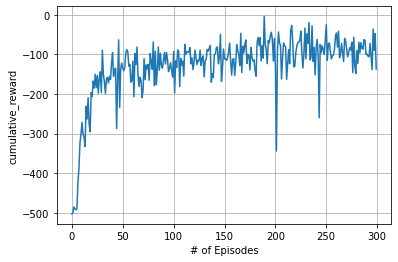

In [13]:
plt.plot(train_logs['cum_rew'])
plt.xlabel('# of Episodes')
plt.ylabel('cumulative_reward')
plt.grid()

In [19]:
avg_test = np.mean(np.array(test_logs['cum_rew']))
avg_test

-44.912237840982165